## Predict how much energy will a building consume with Fedot.Industrial

Dataset published on Kaggle, aims to assess the value of energy efficiency improvements. For that purpose, four types of sources are identified: electricity, chilled water, steam and hot
water. The goal is to estimate the **energy consumption in kWh**. Dimensions correspond to the air temperature, dew temperature, wind direction and wind speed. These values were taken hourly during a week, and the output is the meter reading of the four aforementioned sources. In this way, was created four datasets:  **ChilledWaterPredictor**, **ElectricityPredictor**, **HotwaterPredictor**, and **SteamPredictor**.
Link to the dataset - https://www.kaggle.com/code/fatmanuranl/ashrae-energy-prediction2

In [ ]:
import sys
import os

project_path = r"add_project_path_here\Fedot.Industrial"
sys.path.append(project_path)

In [1]:
import pandas as pd
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
from fedot_ind.api.main import FedotIndustrial
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate

In [3]:
from fedot_ind.core.repository.config_repository import DEFAULT_COMPUTE_CONFIG, DEFAULT_REG_AUTOML_CONFIG, DEFAULT_AUTOML_LEARNING_CONFIG

initial_assumption = {0: ['quantile_extractor', 'treg']}

API_CONFIG = {'industrial_config': {'problem': 'regression'},
              'automl_config': DEFAULT_REG_AUTOML_CONFIG,
              'learning_config': {'learning_strategy': 'from_scratch',
                                  'learning_strategy_params': DEFAULT_AUTOML_LEARNING_CONFIG,
                                  'optimisation_loss': {'quality_loss': 'rmse'}},
              'compute_config': DEFAULT_COMPUTE_CONFIG}
METRIC_NAMES = ('r2', 'rmse', 'mae')
dataset_name = 'SteamPredictor'
data_path = project_path + '/examples/data'

In [ ]:
api_client = ApiTemplate(api_config=API_CONFIG,
                         metric_list=METRIC_NAMES)

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [ ]:
result_dict = api_client.eval(dataset=DATASET_NAME, finetune=True, initial_assumption=initial_assumption)

In [9]:
labels = result_dict['labels']
metrics = result_dict['metrics']

In [10]:
metrics

,r2,rmse,mae
0,0.066,30481.786,11798.198


In [5]:
import numpy as np
features = np.array(train_data[0].tolist()).astype(float)

Lets check our data.

In [6]:
features.shape

(210, 4, 168)

Lets visualise our predictors.

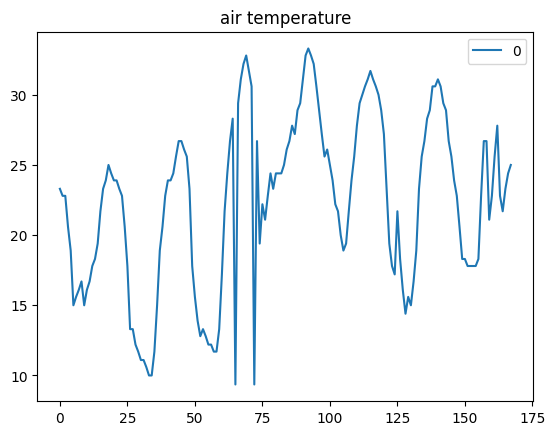

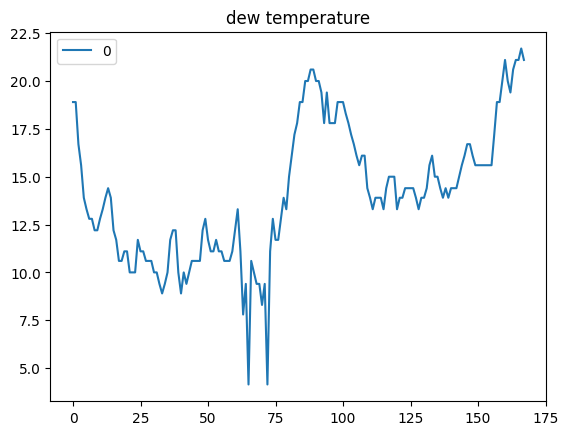

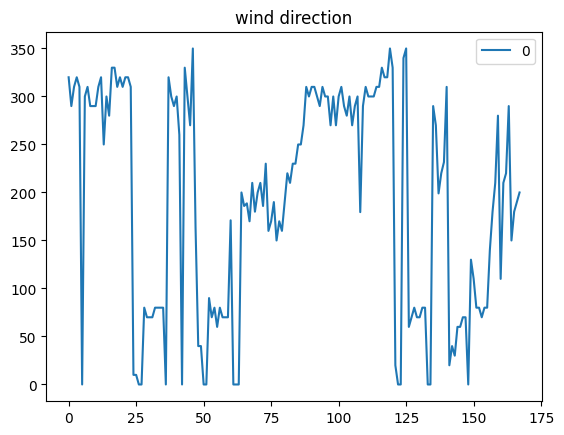

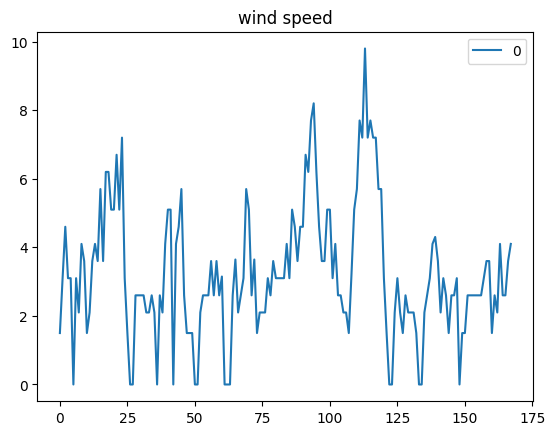

In [7]:
from matplotlib import pyplot as plt
pd.DataFrame(features[1, 0, :]).plot(title='air temperature')
pd.DataFrame(features[1, 1, :]).plot(title='dew temperature')
pd.DataFrame(features[1, 2, :]).plot(title='wind direction')
pd.DataFrame(features[1, 3, :]).plot(title='wind speed')
plt.show()

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

## AutoML approach

In [ ]:
result_dict_auto = api_client.eval(dataset=DATASET_NAME, finetune=False, initial_assumption=initial_assumption)

In [12]:
auto_labels = result_dict_auto['labels']
auto_metrics = result_dict_auto['metrics']

In [13]:
auto_metrics

,r2,rmse,mae
0,0.073,30382.704,11669.433


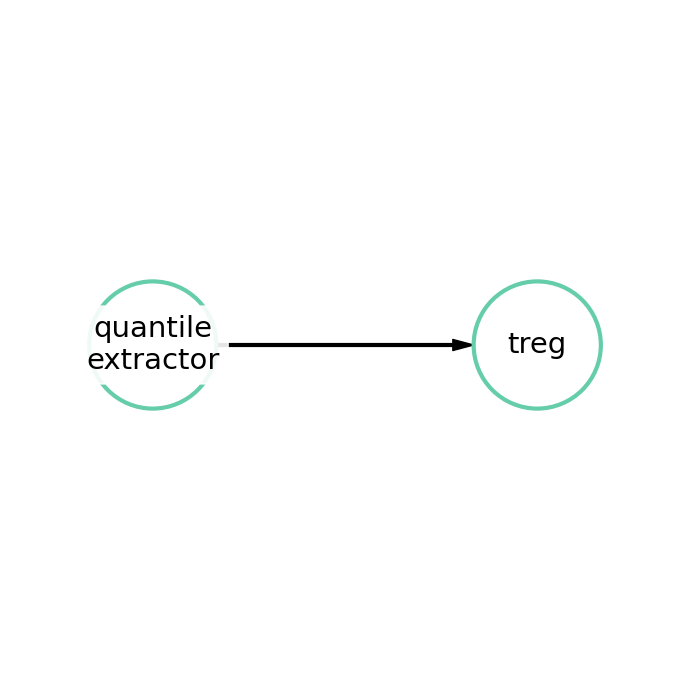

2024-04-05 12:27:29,064 - OperationsAnimatedBar - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-05 12:27:29,205 - MovieWriter ffmpeg unavailable; using Pillow instead.
2024-04-05 12:27:29,206 - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2024-04-05 12:27:36,258 - OperationsAnimatedBar - The animation was saved to "D:\WORK\Repo\Industiral\IndustrialTS\results_of_experiments\history_animated_bars.gif".
2024-04-05 12:27:36,259 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-05 12:27:36,283 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-05 12:27:36,289 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the a

In [14]:
api_client.industrial_class.manager.solver.current_pipeline.show()

# Not implemented yet:

# api_client.industrial_class.plot_operation_distribution(mode='each')
# iapi_client.industrial_class.plot_fitness_by_generation()

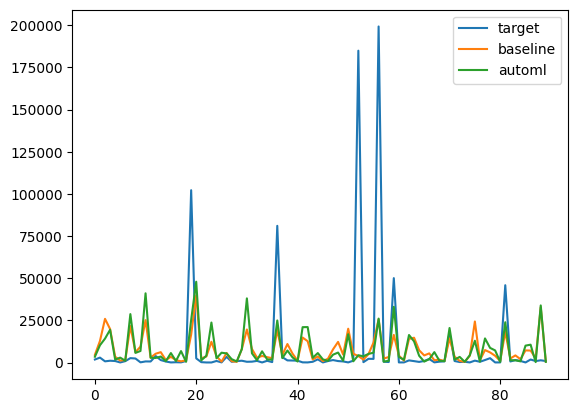

In [15]:
predictions = np.vstack([api_client.test_data[1].flatten(),labels.flatten(),auto_labels.flatten()]).T
all_prediction = pd.DataFrame(predictions,columns=['target','baseline','automl'])
all_prediction.plot()
plt.show()

2024-04-05 12:27:36,530 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-05 12:27:36,551 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-05 12:27:36,557 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


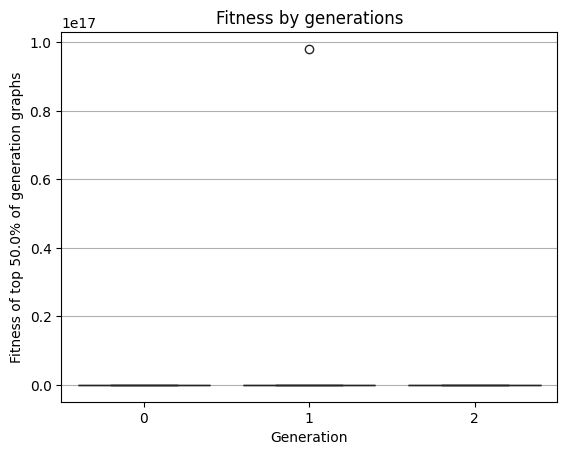

In [16]:
api_client.industrial_class.manager.solver.history.show.fitness_box(best_fraction=0.5, dpi=100)

In [17]:
api_client.industrial_class.manager.solver.return_report()

,days,hours,minutes,seconds,milliseconds
Data Definition (fit),0,0,0,0,0
Data Preprocessing,0,0,0,0,319
Fitting (summary),0,0,30,2,231
Composing,0,0,11,56,613
Train Inference,0,0,0,4,927
Tuning (composing),0,0,18,0,532
Tuning (after),0,0,0,0,0
Data Definition (predict),0,0,0,0,1
Predicting,0,0,0,38,189


2024-04-05 12:27:36,716 - OperationsKDE - Visualizing optimization history... It may take some time, depending on the history size.


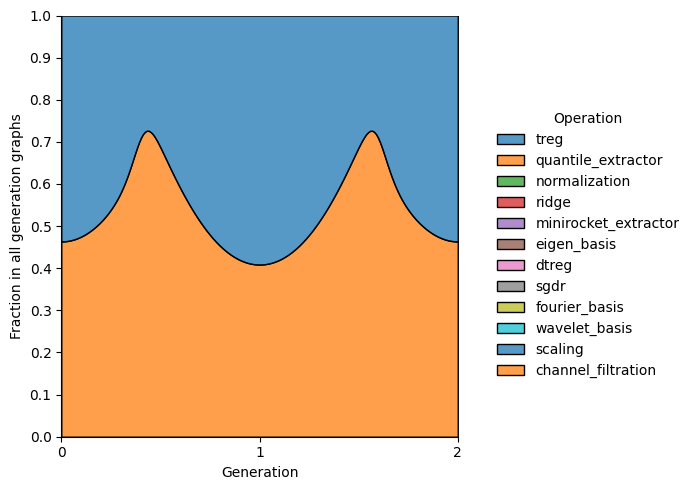

In [18]:
api_client.industrial_class.manager.solver.history.show.operations_kde(dpi=100)

## Compare with State of Art (SOTA) models

In [19]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [20]:
df['Fedot_Industrial_tuned'] = metrics['rmse'][0]
df['Fedot_Industrial_AutoML'] = auto_metrics['rmse'][0]
df = df.T

In [21]:
df.sort_values('min')['min']

Grid-SVR_RMSE              11281.82599
InceptionT_RMSE            11878.07728
SingleInception_RMSE       12076.96550
ResNet_RMSE                13190.55995
CNN_RMSE                   13713.22384
FreshPRINCE_RMSE           15800.64934
TSF_RMSE                   16224.53735
FCN_RMSE                   16378.93547
RotF_RMSE                  16392.91292
DrCIF_RMSE                 16633.91380
MultiROCKET_RMSE           17089.05903
RandF_RMSE                 17464.55070
5NN-DTW_RMSE               18346.81641
ROCKET_RMSE                18707.73368
XGBoost_RMSE               19038.79598
FPCR_RMSE                  19539.47673
FPCR-Bs_RMSE               21007.47494
RDST_RMSE                  26308.46309
RIST_RMSE                  27093.64905
5NN-ED_RMSE                27117.07595
1NN-DTW_RMSE               28780.40955
Fedot_Industrial_AutoML    30382.70400
Fedot_Industrial_tuned     30481.78600
1NN-ED_RMSE                39583.25526
Ridge_RMSE                 61596.26590
Name: min, dtype: float64

In [22]:
df.sort_values('max')['max']

Fedot_Industrial_AutoML    30382.70400
Fedot_Industrial_tuned     30481.78600
RDST_RMSE                  34281.04902
RIST_RMSE                  36322.93964
FCN_RMSE                   39837.12211
FPCR-Bs_RMSE               41198.13017
FPCR_RMSE                  41433.05618
MultiROCKET_RMSE           42408.38274
FreshPRINCE_RMSE           42978.62092
ROCKET_RMSE                43075.96694
ResNet_RMSE                43183.68355
CNN_RMSE                   43662.79467
DrCIF_RMSE                 44117.73585
RandF_RMSE                 44124.97270
SingleInception_RMSE       44206.86270
InceptionT_RMSE            44422.43750
TSF_RMSE                   44700.12218
RotF_RMSE                  44880.77119
Grid-SVR_RMSE              46582.29835
5NN-DTW_RMSE               47398.24409
5NN-ED_RMSE                49043.31025
XGBoost_RMSE               50528.90423
1NN-DTW_RMSE               53184.73404
1NN-ED_RMSE                68682.91455
Ridge_RMSE                 94765.01744
Name: max, dtype: float64

In [23]:
df.sort_values('average')['average']

FCN_RMSE                   29315.72100
ResNet_RMSE                29429.96045
InceptionT_RMSE            29704.37021
SingleInception_RMSE       29823.92480
Fedot_Industrial_AutoML    30382.70400
RDST_RMSE                  30462.40230
Fedot_Industrial_tuned     30481.78600
MultiROCKET_RMSE           30576.84618
CNN_RMSE                   30611.23737
ROCKET_RMSE                30813.80372
FreshPRINCE_RMSE           31014.82503
DrCIF_RMSE                 31131.86635
FPCR_RMSE                  31246.60853
TSF_RMSE                   31357.74909
RotF_RMSE                  31524.69267
FPCR-Bs_RMSE               32018.74692
Grid-SVR_RMSE              32105.48137
RandF_RMSE                 32219.24180
RIST_RMSE                  32431.66763
5NN-DTW_RMSE               34168.97513
XGBoost_RMSE               35238.80806
5NN-ED_RMSE                38081.06224
1NN-DTW_RMSE               42924.76175
1NN-ED_RMSE                55239.47152
Ridge_RMSE                 76160.53072
Name: average, dtype: flo